# Human Activity Recognition Using Video

21BAI1725 SYAM KRISHNNA REDDY PULAGAM

21BAI1796 RAMA KRISHNA REDDY KARRI

In [ ]:
!pip install tensorflow opencv-contrib-python pydot moviepy pafy

# IMPORT REQUIRED LIBRARIES

In [10]:
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d venkatkumar001/human-activity-recognition-ucf50-video-dataset

Dataset URL: https://www.kaggle.com/datasets/venkatkumar001/human-activity-recognition-ucf50-video-dataset
License(s): CC0-1.0
 99% 3.02G/3.04G [00:23<00:00, 169MB/s]
100% 3.04G/3.04G [00:23<00:00, 140MB/s]


In [3]:
!unzip human-activity-recognition-ucf50-video-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: UCF50/HorseRace/v_HorseRace_g08_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c07.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c05.avi  
  inflating: U

Our dataset contains videos labeled as according to their activities that are being performed throughout the video.

In [5]:
import os

def get_subfolder_names(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

folder_path = '/content/UCF50'
labels = get_subfolder_names(folder_path)


In [6]:
print("Number of layers: ",len(labels))
print()
for i in labels:
  print(i)

Number of layers:  50

HorseRiding
JumpingJack
JumpRope
Skijet
MilitaryParade
TrampolineJumping
PlayingViolin
SoccerJuggling
YoYo
SalsaSpin
BenchPress
RopeClimbing
Drumming
Mixing
RockClimbingIndoor
Lunges
CleanAndJerk
WalkingWithDog
PullUps
VolleyballSpiking
HulaHoop
Nunchucks
GolfSwing
Diving
BreastStroke
PoleVault
PommelHorse
ThrowDiscus
PlayingGuitar
JugglingBalls
Fencing
Swing
PizzaTossing
Rowing
Biking
Kayaking
TennisSwing
HighJump
PushUps
Skiing
Billiards
Basketball
TaiChi
PlayingTabla
JavelinThrow
BaseballPitch
HorseRace
PlayingPiano
Punch
SkateBoarding


In [4]:
CLASSES_LIST=['HorseRiding','PoleVault','Skiing']

In [3]:
print(len(CLASSES_LIST))

18


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
    <style>
        body {
            font-size: 80px; /* Adjust this value for body text size */
        }
        table {
            width: 100%;
            border-collapse: collapse;
            font-size: 40px; /* Adjust this value for table text size */
        }
        th, td {
            border: 1px solid #ddd;
            padding: 20px; /* Adjust this value for cell padding */
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>

<h2>Dataset Summary</h2>
<table>
    <tr>
        <th>Feature</th>
        <th>Value</th>
    </tr>
    <tr>
        <td>Action Categories</td>
        <td>50</td>
    </tr>
    <tr>
        <td>Groups of Videos per Action Category</td>
        <td>25</td>
    </tr>
    <tr>
        <td>Average Videos per Action Category</td>
        <td>133</td>
    </tr>
    <tr>
        <td>Average Number of Frames per Video</td>
        <td>199</td>
    </tr>
    <tr>
        <td>Average Frames Width per Video</td>
        <td>320</td>
    </tr>
    <tr>
        <td>Average Frames Height per Video</td>
        <td>240</td>
    </tr>
    <tr>
        <td>Average Frames Per Second per Video</td>
        <td>26</td>
    </tr>
</table>

</body>
</html>


This function will extract the required frames from a video after resizing and normalizing them.

    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()

    return frames_list

In [6]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [11]:
import os
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "/content/UCF50"
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: HorseRiding
Extracting Data of Class: PoleVault
Extracting Data of Class: Skiing


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
one_hot_encoded_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [14]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [15]:
#splitting the dataset into train and test data
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.20, shuffle = True,
                                                                            random_state = seed_constant)

In [16]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    print("Report of Model layer & parameters:")
    model.summary()

    return model

In [17]:
model = create_LRCN_model()

  super().__init__(**kwargs)



Report of Model layer & parameters:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          69,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,947 (292.76 KB)

 Trainable params: 74,947 (292.76 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [20]:
history = model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3553 - loss: 1.1200 - val_accuracy: 0.5750 - val_loss: 0.9346
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5540 - loss: 0.8403 - val_accuracy: 0.6000 - val_loss: 0.7780
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6549 - loss: 0.6345 - val_accuracy: 0.8000 - val_loss: 0.6226
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7540 - loss: 0.5509 - val_accuracy: 0.8500 - val_loss: 0.5070
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8119 - loss: 0.4677 - val_accuracy: 0.8250 - val_loss: 0.4505


In [22]:
model_evaluation_history = model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.8806 - loss: 0.4202


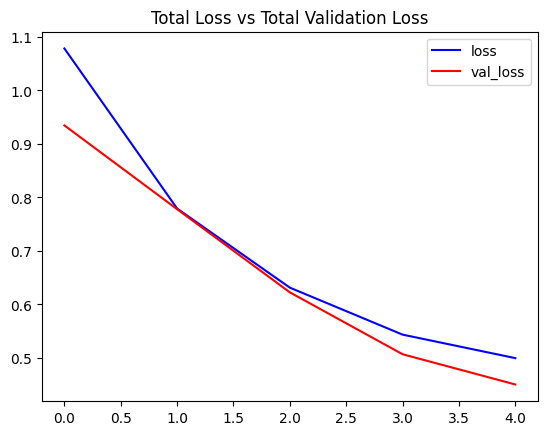

In [24]:
metric_value_1 = history.history['loss']
metric_value_2 = history.history['val_loss']
epochs = range(len(metric_value_1))
plt.plot(epochs, metric_value_1, 'blue', label = 'loss')
plt.plot(epochs, metric_value_2, 'red', label = 'val_loss')
plt.title(str('Total Loss vs Total Validation Loss'))
plt.legend()

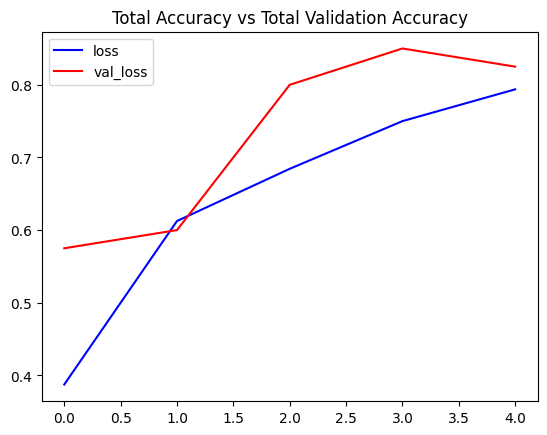

In [25]:
metric_value_1 = history.history['accuracy']
metric_value_2 = history.history['val_accuracy']
epochs = range(len(metric_value_1))
plt.plot(epochs, metric_value_1, 'blue', label = 'loss')
plt.plot(epochs, metric_value_2, 'red', label = 'val_loss')
plt.title(str('Total Accuracy vs Total Validation Accuracy'))
plt.legend()

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

pred = model.predict(features_test)
predicted_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(labels_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:\n", conf_matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Confusion Matrix:
 [[39  1  2]
 [ 8 17  0]
 [ 6  0 28]]


# TESTING

In [44]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            print(CLASSES_LIST[predicted_label])
            predicted_class_name = CLASSES_LIST[predicted_label]
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()
'HorseRiding','PoleVault','Skiing'

In [53]:
SEQUENCE_LENGTH=20
file_path=r"/content/input - Made with Clipchamp.mp4"
output_path=f"Output-SeqLen{SEQUENCE_LENGTH}.mp4"
predict_on_video(file_path, output_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Skiing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Skiing
1/1 ━━━━━━